## 1. Introduction
<p><a href="https://commons.wikimedia.org/wiki/File:Tux.svg">
<img style="float: right;margin:5px 20px 5px 1px" width="150px" src="https://assets.datacamp.com/production/project_111/img/tux.png" alt="Tux - the Linux mascot">
</a></p>
<p>Version control repositories like CVS, Subversion or Git can be a real gold mine for software developers. They contain every change to the source code including the date (the "when"), the responsible developer (the "who"), as well as a little message that describes the intention (the "what") of a change.</p>
<p>In this notebook, we will analyze the evolution of a very famous open-source project &ndash; the Linux kernel. The Linux kernel is the heart of some Linux distributions like Debian, Ubuntu or CentOS. Our dataset at hand contains the history of kernel development of almost 13 years (early 2005 - late 2017). We get some insights into the work of the development efforts by </p>
<ul>
<li>identifying the TOP 10 contributors and</li>
<li>visualizing the commits over the years.</li>
</ul>

In [2]:
# Printing the content of git_log_excerpt.csv
import pandas as pd
git_log_excerpt = pd.read_csv('datasets/git_log_excerpt.csv')
print(git_log_excerpt)

      1502382966#Linus Torvalds
0       1501368308#Max Gurtovoy
1        1501625560#James Smart
2        1501625559#James Smart
3       1500568442#Martin Wilck
4           1502273719#Xin Long
5    1502278684#Nikolay Borisov
6  1502238384#Girish Moodalbail
7   1502228709#Florian Fainelli
8     1502223836#Jon Paul Maloy


## 2. Reading in the dataset
<p>The dataset was created by using the command <code>git log --encoding=latin-1 --pretty="%at#%aN"</code> in late 2017. The <code>latin-1</code> encoded text output was saved in a header-less CSV file. In this file, each row is a commit entry with the following information:</p>
<ul>
<li><code>timestamp</code>: the time of the commit as a UNIX timestamp in seconds since 1970-01-01 00:00:00 (Git log placeholder "<code>%at</code>")</li>
<li><code>author</code>: the name of the author that performed the commit (Git log placeholder "<code>%aN</code>")</li>
</ul>
<p>The columns are separated by the number sign <code>#</code>. The complete dataset is in the <code>datasets/</code> directory. It is a <code>gz</code>-compressed csv file named <code>git_log.gz</code>.</p>

In [4]:
# Loading in the pandas module as 'pd'
import pandas as pd

# Reading in the log file
git_log = pd.read_csv('datasets/git_log.gz', sep='#', encoding='latin-1', header=None, names=['timestamp', 'author'])

# Printing out the first 5 rows
# git_log[:5]
# git_log.head(5)
git_log.head()

,timestamp,author
0,1502826583,Linus Torvalds
1,1501749089,Adrian Hunter
2,1501749088,Adrian Hunter
3,1501882480,Kees Cook
4,1497271395,Rob Clark


## 3. Getting an overview
<p>The dataset contains the information about every single code contribution (a "commit") to the Linux kernel over the last 13 years. We'll first take a look at the number of authors and their commits to the repository.</p>

In [6]:
# calculating number of commits
number_of_commits = git_log.timestamp.value_counts().sum()
# number_of_commits = len(git_log)

# calculating number of authors
number_of_authors = len(git_log.groupby('author'))
# number_of_authors = len(git_log['author'].dropna().unique())

# printing out the results
print("%s authors committed %s code changes." % (number_of_authors, number_of_commits))

17385 authors committed 699071 code changes.


## 4. Finding the TOP 10 contributors
<p>There are some very important people that changed the Linux kernel very often. To see if there are any bottlenecks, we take a look at the TOP 10 authors with the most commits.</p>

In [8]:
# Identifying the top 10 authors
top_10_authors = git_log['author'].dropna().value_counts().head(10)
# top_10_authors = git_log.dropna(subset=['author']).groupby('author').count().sort_values(by='timestamp', ascending=False).head(10)

# Listing contents of 'top_10_authors'
top_10_authors

Linus Torvalds           23361
David S. Miller           9106
Mark Brown                6802
Takashi Iwai              6209
Al Viro                   6006
H Hartley Sweeten         5938
Ingo Molnar               5344
Mauro Carvalho Chehab     5204
Arnd Bergmann             4890
Greg Kroah-Hartman        4580
Name: author, dtype: int64

## 5. Wrangling the data
<p>For our analysis, we want to visualize the contributions over time. For this, we use the information in the <code>timestamp</code> column to create a time series-based column.</p>

In [10]:
# converting the timestamp column
git_log.timestamp = pd.to_datetime(git_log.timestamp, unit='s')

# summarizing the converted timestamp column
git_log.describe()

,timestamp,author
count,699071,699070
unique,668448,17385
top,2008-09-04 05:30:19,Linus Torvalds
freq,99,23361
first,1970-01-01 00:00:01,NaN
last,2037-04-25 08:08:26,NaN


## 6. Treating wrong timestamps
<p>As we can see from the results above, some contributors had their operating system's time incorrectly set when they committed to the repository. We'll clean up the <code>timestamp</code> column by dropping the rows with the incorrect timestamps.</p>

In [12]:
# determining the first real commit timestamp
# first_commit_timestamp = git_log[git_log.author == 'Linus Torvalds'].head(1).timestamp # returns pandas.core.series.Series
# first_commit_timestamp = git_log.sort_values(by='timestamp').head(1).timestamp # will show incorrectly recorded timestamps as well
first_commit_timestamp = git_log.iloc[-1]['timestamp'] # returns pandas._libs.tslibs.timestamps.Timestamp
display(first_commit_timestamp)


# determining the last sensible commit timestamp
# last_commit_timestamp = git_log[git_log.timestamp <= pd.to_datetime('2018-01-01')].sort_values('timestamp').tail(1).timestamp # returns pandas.core.series.Series
last_commit_timestamp = pd.to_datetime('2018') # returns pandas._libs.tslibs.timestamps.Timestamp
display(last_commit_timestamp) 

# filtering out wrong timestamps
corrected_log = git_log[(git_log.timestamp >= first_commit_timestamp) & (git_log.timestamp <= last_commit_timestamp)]

# summarizing the corrected timestamp column
corrected_log.describe()

Timestamp('2005-04-16 22:20:36')

Timestamp('2018-01-01 00:00:00')

,timestamp,author
count,698569,698568
unique,667977,17375
top,2008-09-04 05:30:19,Linus Torvalds
freq,99,23361
first,2005-04-16 22:20:36,NaN
last,2017-10-03 12:57:00,NaN


## 7. Grouping commits per year
<p>To find out how the development activity has increased over time, we'll group the commits by year and count them up.</p>

In [14]:
# Counting the no. commits per year
commits_per_year = corrected_log.groupby(pd.Grouper(key='timestamp', freq='AS'))['timestamp'].count() # freq AS = Annual Start-day
# commits_per_year = corrected_log.groupby(pd.Grouper(key='timestamp', freq='AS')).count() # freq AS = Annual Start-day

# Listing the first rows
print(commits_per_year)

timestamp
2005-01-01    16230
2006-01-01    29255
2007-01-01    33759
2008-01-01    48847
2009-01-01    52572
2010-01-01    49819
2011-01-01    56403
2012-01-01    65389
2013-01-01    71001
2014-01-01    75642
2015-01-01    75747
2016-01-01    76688
2017-01-01    47217
Freq: AS-JAN, Name: timestamp, dtype: int64


## 8. Visualizing the history of Linux
<p>Finally, we'll make a plot out of these counts to better see how the development effort on Linux has increased over the the last few years. </p>

DEBUG:matplotlib:CACHEDIR=/home/repl/.cache/matplotlib
DEBUG:matplotlib:matplotlib data path: /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data
DEBUG:matplotlib.font_manager:font search path [PosixPath('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf'), PosixPath('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/afm'), PosixPath('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/pdfcorefonts')]
INFO:matplotlib.font_manager:generated new fontManager
DEBUG:matplotlib:CONFIGDIR=/home/repl/.config/matplotlib
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia_Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Andale Mono' (andalemo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS_Bold_Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia_Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal 700 normal>) = 10.335
DEBUG:ma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal roman normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times_New_Roman_Italic.ttf) italic normal roman normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal no

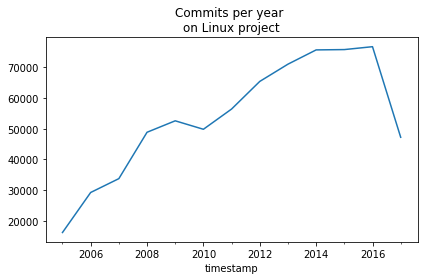

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [16]:
# Setting up plotting in Jupyter notebooks
%matplotlib inline

# plot the data
commits_per_year.plot(kind='line', title='Commits per year \non Linux project', legend=None)

## 9.  Conclusion
<p>Thanks to the solid foundation and caretaking of Linux Torvalds, many other developers are now able to contribute to the Linux kernel as well. There is no decrease of development activity at sight!</p>

In [18]:
# calculating or setting the year with the most commits to Linux
# year_with_most_commits = commits_per_year[commits_per_year == commits_per_year.max()].index.year # Int64Index([2016], dtype='int64', name='timestamp')
# year_with_most_commits = 2016
year_with_most_commits = commits_per_year[commits_per_year == commits_per_year.max()].index.year[0]
# year_with_most_commits = commits_per_year.where(commits_per_year == commits_per_year.max()).dropna().index.year[0]
print(year_with_most_commits)

2016
